In [ ]:
%%capture 
!pip install pymc

In [ ]:
import os 
import sys
# data handling
import pymc as pm
import numpy as np
# mathematical library
import scipy.stats as stats
import scipy.optimize as opt
# plotting
from matplotlib import rc
from matplotlib import style 
import matplotlib.pyplot as plt
style.use('seaborn-bright')
plt.rcParams['axes.grid'] : True
plt.rcParams['font.family'] = "serif"
# colab
from google.colab import drive
drive.mount('/content/gdrive')
# warining supression
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


## **Prior and posterior distribution sampling**
Example: <i>The price is right contestant<i/>
<br>
Rules: 
1. Two contestants compete in the Showcase. 
2. Each contestant is shown a unique suite of prizes 
3. After viewing, contestants are asked to bid price for their unique suite of prizes
4. If a bid price is over actual price, the bid's owner is disqualified from winning. 
5. If bid price is under actual price <b>within</b> £250, the winner is awarded both prizes.

<br>
Prior beliefs of total price history of show. Assume to be normally distributed, say:
<br>
True Price ~ $N(\mu_{prior}, \sigma_{prior})$,
<br>
Where $\mu_{prior}$ = 35000 and $\sigma_{prior} = 7500$.
<br>
<br>
Suppose your belief about prizes is that they follow a normal distribution:
<br>
$Prize_{i}$ ~ $N(\mu_{i}, \sigma_{i})$, i= 1,2 
<br>
<br>
(Note how we can include uncertainty through $\sigma_{i}$ about initial guesses, $\mu_{i}$, via Bayesian approach.)

<br>
<br>
True price of suite is given by:<br>
True Price  = $Prize_{1}$ + $Prize_{2}$ + $\epsilon$ <br>
Where $\epsilon$ is some error term

#### **Distribution parameter assignment**
Suite of prizes: <br>
- $Prize_{1}$: $\mu_{1}$ = £3000, $\sigma_{1}$ = £500
- $Prize_{2}$: $\mu_{2}$ = £12000, $\sigma_{2}$ = £3000

In [ ]:
data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
mu_prior = 35e3
std_prior = 75e2

#### **Distributions plotting**

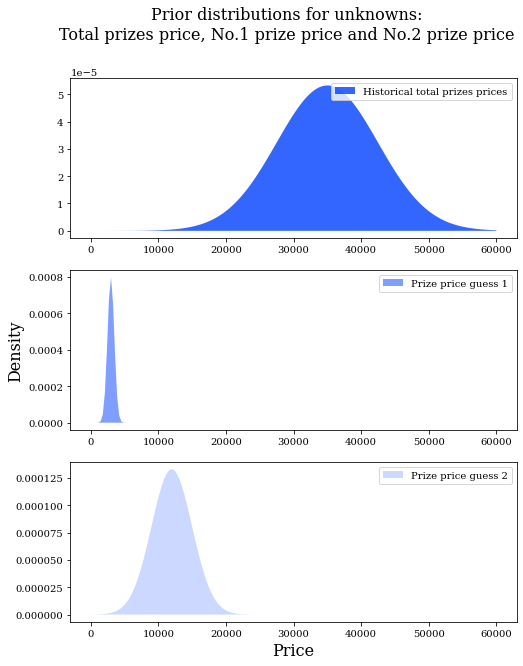

In [ ]:
def prior_distribution_plot(num_plots, title):
  norm_pdf = stats.norm.pdf
  x = np.linspace(0, 60000, 200)
  fig, ax = plt.subplots(num_plots, 1)
  fig.set_figwidth(8)
  fig.set_figheight(10)
  fig.suptitle(f'{title}', size=16)
  sp1 = ax[0].fill_between(x, y1=0, y2=norm_pdf(x, loc=mu_prior, scale=std_prior), lw=3, alpha=0.8, label='Historical total prizes prices')
  p1 = plt.Rectangle( (0,0), 1,1, fc= sp1.get_facecolor()[0])
  ax[0].legend([p1], [sp1.get_label()])

  sp2 = ax[1].fill_between(x, y1=0, y2=norm_pdf(x, loc=data_mu[0], scale=data_std[0]), lw=3, alpha=0.5, label='Prize price guess 1')
  p2 = plt.Rectangle((0,0), 1, 1, fc=sp2.get_facecolor()[0])
  ax[1].legend([p2], [sp2.get_label()])

  sp3 = ax[2].fill_between(x, y1=0, y2=norm_pdf(x, loc=data_mu[1], scale=data_std[1]), lw=3, alpha=0.2, label= 'Prize price guess 2')
  p3 = plt.Rectangle((0,0), 1, 1, fc=sp3.get_facecolor()[0])
  ax[2].legend([p3], [sp3.get_label()])
  plt.xlabel('Price', size=16)
  ax[1].set_ylabel('Density', size=16)
  if num_plots ==4:
    fig.set_figheight(14)
    ax[3].plot(x, norm_pdf(x, loc=35000, scale=7500), c='k', lw=2, label='Prior distribtuion\nof suite prices')
    hist = ax[3].hist(price_trace, bins=35, density=True, alpha=0.2, histtype='stepfilled', color='k', label='Posterior of true price estimate')
    ax[3].vlines(mu_prior, 0, 1.1*np.max(hist[0]), label='prior\'s mean', ls='--' )
    ax[3].vlines(price_trace.mean(), 0, 1.1*np.max(hist[0]), label='Posterior\'s mean', ls='-.')
    ax[3].legend()


prior_distribution_plot(num_plots=3, title='Prior distributions for unknowns:\nTotal prizes price, No.1 prize price and No.2 prize price')

#### **Monte-carlo markov chain**

Sampling from relation: <br>
True Price  = $Prize_{1}$ + $Prize_{2}$ + $\epsilon$ <br>



In [ ]:
true_price = pm.Normal('True_price', mu = mu_prior, tau=1.0/std_prior**2)
prize1 = pm.Normal('First_prize', mu=data_mu[0], tau=1.0/data_std[0]**2)
prize2 = pm.Normal('Second_prize', mu=data_mu[1], tau=1.0/data_std[1]**2)
price_estimate = prize1 + prize2

@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
  return pm.normal_like(x=true_price, mu=price_estimate, tau=1.0/(3e3)**2)

mcmc = pm.MCMC([true_price, prize1, prize2, price_estimate, error])
mcmc.sample(iter=50000, burn=10000)
price_trace = mcmc.trace('True_price')[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 4.6 sec

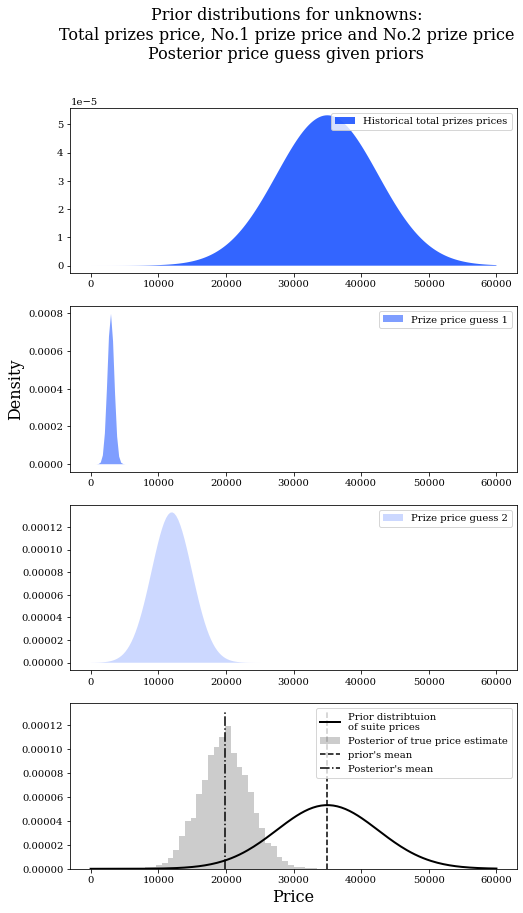

In [ ]:
prior_distribution_plot(num_plots=4, title='Prior distributions for unknowns:\nTotal prizes price, No.1 prize price and No.2 prize price\nPosterior price guess given priors')

#### **Loss function with risk factor**
How to include decision payoff in loss function? <br>
Minimize the <ins>expected loss</ins> (a.k.a <b>risk</b>) and not just precision focused loss<br><br>
$argmin$$_{\hat{\theta}}$ $E$ $\Big[$ $L$ ($\theta$, $\hat{\theta}$) $\Big]$<br><br>
Minimum of expected loss (with respect to different risk levels) is called: 
<br>
<b>Bayes action</b>

In [ ]:
def showcase_loss(yp, y, risk=8000):
  '''input: single element'''
  if y < yp: # predict over 
    return risk 
  elif np.abs(y - yp) < 250: # predict witin 250
    return -2 * np.abs(y)
  else:
    return np.abs(y- yp - 250) # predict below 250 threshold

def showdown_loss(yp, y, risk=80000):
  '''input: array of elements. loss function'''
  loss = np.zeros_like(y) # place holder
  ix = y < yp # i.d. for over predictions
  loss[~ix] = np.abs(yp - y[~ix]) #i.ds with under prediction, difference 
  close_mask = [abs(y - yp) <=250] # mask predictions within 250 of truth
  loss[close_mask] = -2*y[close_mask] # NOTE  ====>  NEGATIVE LOSS = WIN! 
  loss[ix] = risk 
  return loss

#### **Expected loss for varying risk factor**

Text(0.5, 1.0, 'Expected loss of different price guesses\nvarious risk levels of over-estimating')

Text(0.5, 0, 'Price bid')

Text(0, 0.5, 'Expected loss')

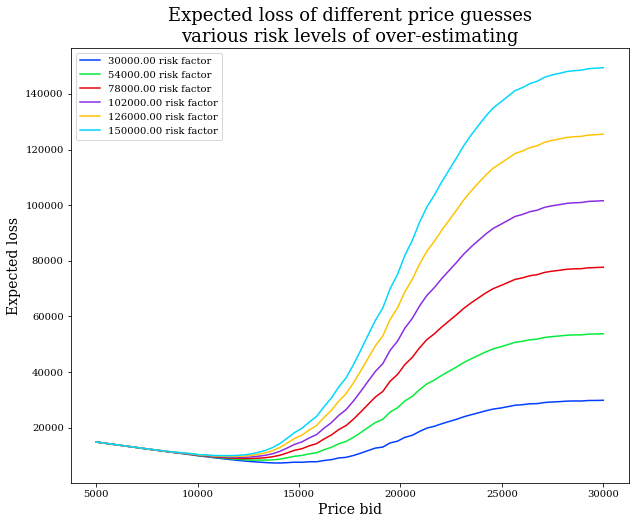

In [ ]:
yp = np.linspace(5000, 30000, 70)
risks = np.linspace(30000, 150000, 6)

fig = plt.figure()
ax = plt.subplot(111)
fig.set_figwidth(10)
fig.set_figheight(8)

expected_loss = lambda yp, risk: showdown_loss(yp, price_trace, risk).mean()

for risk in risks: 
  results = [expected_loss(predict, risk) for predict in yp]
  ax.plot(yp, results, label=f'{risk:.2f} risk factor')

ax.legend()
plt.title('Expected loss of different price guesses\nvarious risk levels of over-estimating', size=18)
plt.xlabel('Price bid', size=14)
plt.ylabel('Expected loss', size=14)

#### **Optmizing for Bayes optimal action**



========= Minimum at risk 30000.0: 13760.41 =========





========= Minimum at risk 54000.0: 12954.89 =========





========= Minimum at risk 78000.0: 12545.67 =========





========= Minimum at risk 102000.0: 12001.56 =========





========= Minimum at risk 126000.0: 11927.75 =========





========= Minimum at risk 150000.0: 11379.10 =========



Text(0.5, 1.0, 'Expected loss and Bayes actions of different predictions,\nvarious risk levels of over-estimation')

Text(0.5, 0, 'Total price guess')

Text(0, 0.5, 'Expected loss')

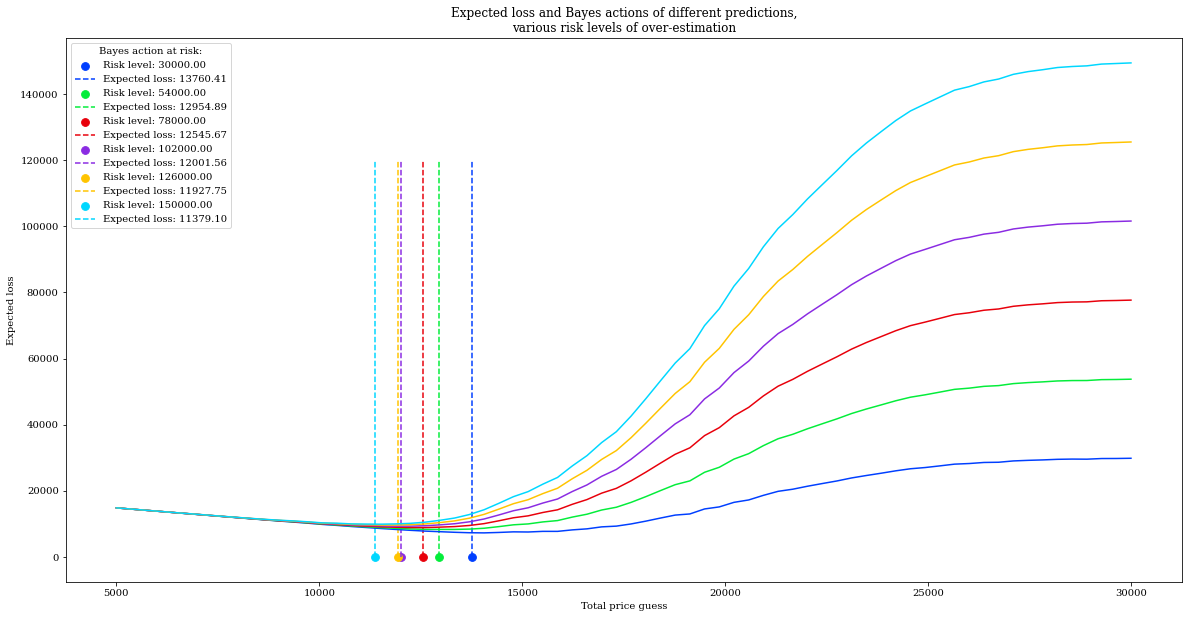

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

fig.set_figheight(10)
fig.set_figwidth(20)
for risk in risks:
  colour = ax._get_lines.get_next_color()
  min_results = opt.fmin(func=expected_loss, x0=15000, args=(risk,), disp=0)
  results = [expected_loss(y_p, risk) for y_p in yp]
  plt.plot(yp, results, color=colour)
  plt.scatter(x=min_results, y=0, s=60, color=colour, label= f'Risk level: {risk:.2f}')
  plt.vlines(min_results, 0, 120000, color=colour, ls='--', label=f'Expected loss: {min_results[0]:.2f}')
  print(f'\n\n========= Minimum at risk {risk}: {min_results[0]:.2f} =========\n')
  
plt.title('Expected loss and Bayes actions of different predictions,\nvarious risk levels of over-estimation')
plt.legend(loc='upper left', scatterpoints=1, title='Bayes action at risk:')
plt.xlabel('Total price guess')
plt.ylabel('Expected loss')



### **Financial predictions return: loss function**
Financial institutions treat downside risk (predicting a lot on wrong side) and upside risk (predicting a lot wrong on right side) the same. <br>
Need loss function to capture this preference.  

(0.0, 0.1)

(-0.05, 0.06)

Text(0.5, 1.0, 'Stock returns loss given true values: 0.05% and -0.02%\n with varying alpha/risk levels')

Text(0.5, 0, 'Precentage returns')

Text(0, 0.5, 'Loss')



Note how the loss function changes in regime once sign of prediction is altered.


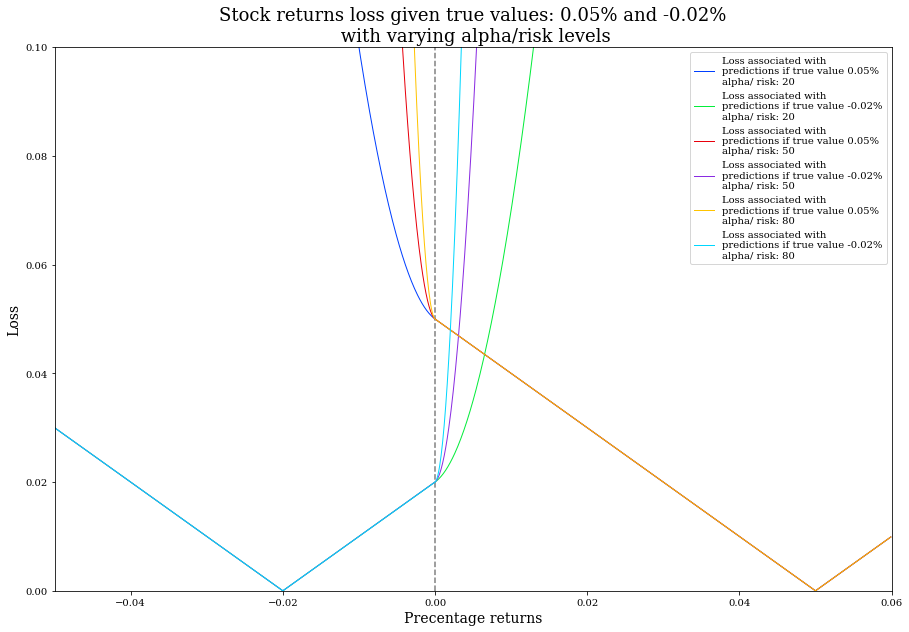

In [ ]:
def financial_asset_loss(y, yp, alpha=100.):

  if y * yp <0: # prediction has OPPOSITE sign to true value
    return (alpha* yp)**2 - np.sign(y)*yp + np.abs(y)

  else:         # prediction has SAME sign to ture value   
    return np.abs(y - yp)


ys = [0.05, -0.02]                    # True returns 
yps = np.arange(-0.05, 0.06, 0.0001)  # predicted returns 
alphas = np.arange(20, 100, 30)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
ax = plt.subplot(111)

for a in alphas:
  for idx, y in enumerate(ys):
    ax.plot(yps,[financial_asset_loss(y, yp, alpha=a) for yp in yps], label=f'Loss associated with\npredictions if true value {y:.2f}%\nalpha/ risk: {a}', lw=1)

plt.vlines(x=0.0, ymin=0.0, ymax=1, ls='--', color='grey')
plt.ylim([0,0.1])
plt.xlim([-0.05,0.06])
plt.legend()
plt.title(f'Stock returns loss given true values: {ys[0]}% and {ys[1]}%\n with varying alpha/risk levels', size=18)
plt.xlabel('Precentage returns', size=14)
plt.ylabel('Loss', size=14)
print('\n\nNote how the loss function changes in regime once sign of prediction is altered.')

#### **Financial data trading signal simulation**
Perform regression on trading signal that is believed to predict future returns well. <br>
NOTE: Dataset is artifical $\rightarrow$ Financial data is non-linear.

Text(0.5, 1.0, 'Emperical returns versus trading signal')

Text(0.5, 0, 'Trading signal')

Text(0, 0.5, 'Emperical returns')

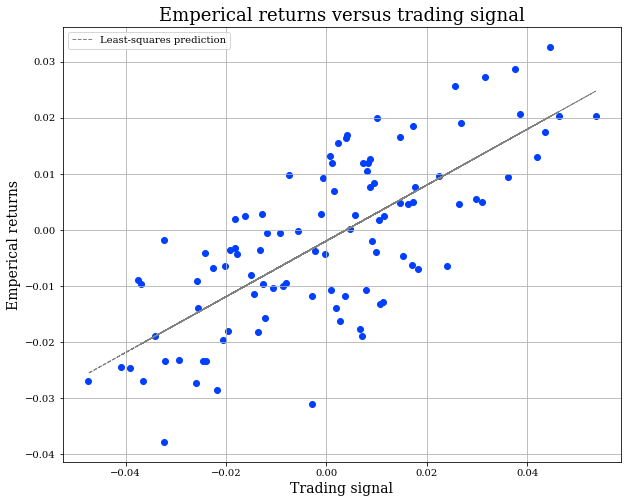

In [36]:
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N)

ls_coef = np.cov(X,Y)[0,1]/np.var(X)

ls_intercept = Y.mean() - ls_coef *X.mean()

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(10)

ax = plt.subplot(111)
ax.set_title('Emperical returns versus trading signal', size=18)
ax.scatter(X, Y)
ax.plot(X, ls_coef * X + ls_intercept, '--', color='grey', lw=1, label='Least-squares prediction')

ax.set_xlabel('Trading signal', size=14)
ax.set_ylabel('Emperical returns', size=14)
ax.legend()
ax.grid(True)

#### **Performing simple Bayesian linear regression**
Relation: <br>
$Return$ = $\alpha$ + $\beta$x + $\epsilon$ <br>
Where:- 
- $\alpha$ and $\beta$ are unknown 
- $\epsilon$ ~ $N$ $\Big($0, $\frac{1}{\tau}$ $\big)$

<br>
Normal priors for $\alpha$ and $\beta$ are common <br>
Assign prior on $\tau$ such that: <br><br>
$\sigma$ = $\frac{1}{\sqrt{\tau}}$ is uniform 
over 0 to 100. $\rightarrow$ $\tau$  = $\frac{1}{Uniform(0,100)^{2}}$


In [39]:
std = pm.Uniform('std', 0 , 100, trace=False)
@pm.deterministic 
def precision(U=std):
  return 1/U**2

beta = pm.Normal(name='beta', mu=0, tau=0.0001)
alpha = pm.Normal(name='alpha', mu=0, tau=0.0001)

@pm.deterministic 
def mean(X=X, alpha=alpha, beta=beta):
  return alpha + beta * X

observations = pm.Normal(name='obs', mu=mean, tau=precision, value=Y, observed=True)
mcmc = pm.MCMC([observations, beta, alpha, std, precision])
mcmc.sample(100000, 80000)

 [-----------------100%-----------------] 100000 of 100000 complete in 9.8 sec

Consider specific trading signal, $x$, distribution of possible returns has the form:<br><br>
$Returns_{i}(x)$ = $\alpha_{i}$ + $\beta_{i}$ $x$ + $\epsilon$<br><br>

$\epsilon$ ~ $N$(0, $\frac{1}{\tau_{i}}$)<br><br>

Where $i$ indexes our posterior samples.<br><br>

Want to minimize: <br>
$argmin$$_{r}$ $E_{R(x)}$ $\Big[$ $L$( $R(x)$, $r$) $\Big]$,<br>
Where $r$ is our Bayes action for signal $x$



#### **Bayesian action** $r$ **over different trading signals**

Text(0.5, 0, 'Training signal')

Text(0, 0.5, 'Prediction')

Text(0.5, 1.0, 'Least-squares predictions versus Bayes action prediction')

(-0.06449753699345441, 0.05786990574502138)

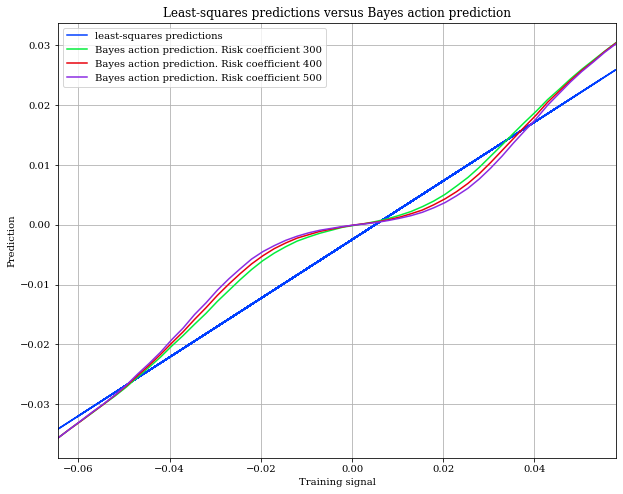

In [35]:
def stock_loss(price, prediction, coef=500):
  solution = np.zeros_like(price)
  ix = price * prediction < 0  # opposite signals
  solution[ix] = coef*prediction**2 - np.sign(price[ix])*prediction + np.abs(price[ix])
  solution[~ix] = np.abs(price[~ix] -prediction)
  return solution 

tau_samples = mcmc.trace('precision')[:]
alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]

N = tau_samples.shape[0]
noise = 1./np.sqrt(tau_samples) * np.random.randn(N)
possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise

optimal_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)

coefficient = np.arange(300, 600, 100)

predictions = []
for c in coefficient:
  optimal_predictions_c = []

  for i, signal in enumerate(trading_signals):
    possible_outcome = possible_outcomes(signal)
    tomin = lambda predictions: stock_loss(possible_outcome, predictions, coef=c).mean()
    optimal_predictions_c.append(opt.fmin(tomin, 0, disp=False))
    
  predictions.append(optimal_predictions_c)


fig = plt.figure(figsize=(10,8))
plt.xlabel('Training signal')
plt.ylabel('Prediction')
plt.title('Least-squares predictions versus Bayes action prediction')

plt.plot(X, ls_coef*X + ls_intercept, label='least-squares predictions')
plt.xlim(X.min(), X.max())
for i,p in enumerate(predictions):
  plt.plot(trading_signals, p, label=f'Bayes action prediction. Risk coefficient {coefficient[i]}')

plt.legend()
plt.grid(True)

When close to trading signal at 0 return, Bayes action $r$ predicts on conservative side compared to least-squares prediction. Reflective of risk-aversive behaviour. When unconfident about prediction, do not enter position. With more confidence, we predict with higher stakes.  